<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#作业要求" data-toc-modified-id="作业要求-1">作业要求</a></span></li><li><span><a href="#一-变量选择" data-toc-modified-id="一-变量选择-2">一 变量选择</a></span><ul class="toc-item"><li><span><a href="#1-划分训练集和测试集" data-toc-modified-id="1-划分训练集和测试集-2.1">1 划分训练集和测试集</a></span></li><li><span><a href="#2-用训练集数据进行变量选择" data-toc-modified-id="2-用训练集数据进行变量选择-2.2">2 用训练集数据进行变量选择</a></span></li></ul></li><li><span><a href="#二-模型分割" data-toc-modified-id="二-模型分割-3">二 模型分割</a></span></li><li><span><a href="#三-模型训练、测试和分析" data-toc-modified-id="三-模型训练、测试和分析-4">三 模型训练、测试和分析</a></span><ul class="toc-item"><li><span><a href="#1-模型训练和测试" data-toc-modified-id="1-模型训练和测试-4.1">1 模型训练和测试</a></span></li><li><span><a href="#2-模型分析" data-toc-modified-id="2-模型分析-4.2">2 模型分析</a></span></li></ul></li></ul></div>

### 作业要求
利用鲍鱼的数据构建一组线性模型 y=aX+b，预测鲍鱼的年龄（即rings）。  
输入变量（自变量X,多维度）是鲍鱼的身体特征和性别，相应变量（Y）。  
构建模型的时候可以体现出数据挖掘流程中的变量选择、模型分割、模型训练、测试的理念，汇报模型的训练和测试误差，推荐你认为最佳的模型，并说明理由。


本次作业我首先划分训练集和测试集，然后在训练集上使用基于L1惩罚项的特征选择法来进行变量选择，知道应该剔除Length变量。然后根据性别进行模型分割，训练出三个模型，下面是模型及得分。最后对模型进行分析和解释，发现分割后能区分特征在不同组的效果。结合模型得分和解释性，以及残差图，我们认为这是可取的模型。
- F组：$Rings = 3.14\times Diameter + 1.87\times Height + 9.66\times WholeWeight -20.82\times ShuckedWeight -7.3\times VisceraWeight + 8.83\times ShellWeight + 7.56$
- M组：$Rings = 5.61\times Diameter + 10.22\times Height + 8.72\times WholeWeight -18.91\times ShuckedWeight -11\times VisceraWeight + 12.07\times ShellWeight + 5.19$
- I组：$Rings = 5.34\times Diameter + 23.98\times Height + 10.73\times WholeWeight -17.83\times ShuckedWeight -16.3\times VisceraWeight + 8.89\times ShellWeight + 2.69$      

模型$R^2$得分：  

|      | 测试集 | 训练集 |
| :---- | :------ | :------ |
| F组  | 0.32   | 0.37   |
| M组  | 0.40   | 0.45   |
| I组  | 0.59   | 0.58   |

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)    # 输出精度
np.set_printoptions(suppress=True)  # 输出不用科学计数法
np.set_printoptions(threshold=np.inf)   # 没有省略号
pd.set_option('precision', 2)   # 设置精度
pd.set_option('display.float_format', lambda x: '%.2f' % x)    # 输出不用科学计数法

In [2]:
# 读入数据，同时指定Sex是分类变量，Rings是整数数值变量，其他列都是浮点型数值变量
df = pd.read_csv("./abalone.txt",header=None, 
                 names=['Sex', 'Length','Diameter','Height',
                        'WholeWeight','ShuckedWeight','VisceraWeight','ShellWeight','Rings'],
                 dtype={'Sex':'category','Rings':'int'})
# 查看数据的前5行
df.head()

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.46,0.36,0.10,0.51,0.22,0.10,0.15,15
1,M,0.35,0.27,0.09,0.23,0.10,0.05,0.07,7
2,F,0.53,0.42,0.14,0.68,0.26,0.14,0.21,9
3,M,0.44,0.36,0.12,0.52,0.22,0.11,0.15,10
4,I,0.33,0.26,0.08,0.20,0.09,0.04,0.06,7


In [3]:
# 查看分类型变量的描述性统计信息，包括总个数、取值类数、众数、众数对应的出现次数
# 分类变量只有性别一个
df.describe(include='category')

,Sex
count,4177
unique,3
top,M
freq,1528


In [4]:
# 查看数值变量的描述性统计信息，包括总个数、平均值、标准差、最小值、3个四分位数、最大值
# 鲍鱼的Rings和身体特征都是数值变量
df.describe()

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
count,4177.00,4177.00,4177.00,4177.00,4177.00,4177.00,4177.00,4177.00
mean,0.52,0.41,0.14,0.83,0.36,0.18,0.24,9.93
std,0.12,0.10,0.04,0.49,0.22,0.11,0.14,3.22
min,0.07,0.06,0.00,0.00,0.00,0.00,0.00,1.00
25%,0.45,0.35,0.12,0.44,0.19,0.09,0.13,8.00
50%,0.55,0.42,0.14,0.80,0.34,0.17,0.23,9.00
75%,0.61,0.48,0.17,1.15,0.50,0.25,0.33,11.00
max,0.81,0.65,1.13,2.83,1.49,0.76,1.00,29.00


### 一 变量选择
我们这里使用的是基于L1惩罚项的特征选择法，原理是通过对损失函数(即优化目标)加入L1惩罚项，使得训练求解参数过程中会考虑到特征系数的大小，从而会使得对Rings影响较小的特征的系数衰减到0，达到只保留重要特征的效果。  
而且，我们的变量选择只在训练集上进行，即通过训练集数据结果决定使用哪些变量，不蕴含测试集的信息，这与真实环境更相似。  
所以下面先进行训练集和测试集的划分，然后用训练集数据来进行基于L1惩罚项的特征选择。

- 使用正则项进行变量选择的结果与课上同学演示的结果类似，也把Length变量剔除了。  
- 特征选取并不一定提升模型效果：所有特征有效的情况下，去除特征只能带来模型性能的下降；退一步，不重要的特征也并不一定会导致模型性能下降。

#### 1 划分训练集和测试集

In [5]:
# 划分训练集和测试集，划分X和y（此时X和y都带了’Sex‘列，方便后面按Sex划分组）
train_set, test_set = train_test_split(df, train_size=0.7, test_size=0.3, random_state=0)
train_X = train_set.drop(['Rings'],axis=1)
train_y = train_set[['Rings','Sex']]
test_X = test_set.drop(['Rings'],axis=1)
test_y = test_set[['Rings','Sex']]

#### 2 用训练集数据进行变量选择

In [6]:
# 用训练集数据进行变量选择
clf = LassoCV(cv=5, random_state=0)    # 初始化L1正则项的线性分类器，设置random_state保证复现结果一致，交叉验证设置为5折
sfm = SelectFromModel(estimator=clf)    # 根据线性分类器的系数来进行特征选择，系数的默认阈值是1e-5（剔除系数小于1e-5的特征）
sfm.fit(train_X.drop(['Sex'],axis=1), train_y.drop(['Sex'],axis=1))    # 进行拟合
print("线性分类器各特征",train_X.drop(['Sex'],axis=1).columns)
print("线性分类器各特征的系数：",sfm.estimator_.coef_)    # 查看线性分类器的各特征的系数
print("\n选出的特征：",train_X.drop(['Sex'],axis=1).columns[sfm.get_support()]) 

线性分类器各特征 Index(['Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight',
       'VisceraWeight', 'ShellWeight'],
      dtype='object')
线性分类器各特征的系数： [  0.    11.21   5.99   7.96 -19.09  -6.68  10.65]

选出的特征： Index(['Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight',
       'ShellWeight'],
      dtype='object')


### 二 模型分割
按照老师上课讲的模型分割，意思是从业务理解上，根据变量的取值不同，将不同取值的样本用来训练不同的模型。
- 像我们这次作业的鲍鱼数据，I组的鲍鱼，从常识（业务理解）上来说，年龄与体长关联应该较大，因为婴儿时期随着年龄增长，体长也增长；而F和M组已经成年，年龄和体长关联不大。
- 所以，相比将性别作为特征只预测一个模型，我们觉得按照性别分成三组，得到三个模型，应该会在测试集上整体表现更好。

注意要点：考虑到模型的实际使用，希望是划分成组，让已有数据和暂未出现但以后可能有的数据都能找到自己对应的组。而不是极限情况下每个取值成为一类，这样新测试数据出现时就无法找到对应模型来预测了。这里的性别是分类变量，就是天然的分组，而且实际使用时的鲍鱼数据不会有新的性别取值了，所以这三个模型就可以保证全覆盖所有已有的或未出现的鲍鱼数据。

In [7]:
# 先按照性别对数据进行分割，然后用分割后的数据进行训练和测试
def split_model_train_and_test(sex,train_X,train_y,test_X,test_y):
    train_X = train_X[train_X.Sex==sex].drop(['Sex','Length'],axis=1)    # 用剔除Length后的X
    train_y = train_y[train_y.Sex==sex].drop(['Sex'],axis=1)
    test_X = test_X[test_X.Sex==sex].drop(['Sex','Length'],axis=1)    # 用剔除Length后的X
    test_y = test_y[test_y.Sex==sex].drop(['Sex'],axis=1)
    return train_and_test(train_X,train_y,test_X,test_y)

### 三 模型训练、测试和分析
这部分我们按照性别进行的模型划分，也除去了Length特征，分别进行模型训练和测试，得到了模型参数和模型在训练集和测试集上的得分，并绘制残差图。  
我们还对得到的特征系数进行分析，分析从系数大小、正负，以及不同模型之间系数的差异角度进行。  

#### 1 模型训练和测试
(1) 最终模型是：
- F组：$Rings = 3.14\times Diameter + 1.87\times Height + 9.66\times WholeWeight -20.82\times ShuckedWeight -7.3\times VisceraWeight + 8.83\times ShellWeight + 7.56$
- M组：$Rings = 5.61\times Diameter + 10.22\times Height + 8.72\times WholeWeight -18.91\times ShuckedWeight -11\times VisceraWeight + 12.07\times ShellWeight + 5.19$
- I组：$Rings = 5.34\times Diameter + 23.98\times Height + 10.73\times WholeWeight -17.83\times ShuckedWeight -16.3\times VisceraWeight + 8.89\times ShellWeight + 2.69$      

(2) 模型得分如下：  

|      | 测试集 | 训练集 |
| :---- | :------ | :------ |
| F组  | 0.32   | 0.37   |
| M组  | 0.40   | 0.45   |
| I组  | 0.59   | 0.58   |

(3) 残差图分析：  
有点扇形分布，可能不太好

In [38]:
# 输入数据，返回模型和测试集得分、训练集得分，并绘制残差图，得分是R方
def train_and_test(train_X,train_y,test_X,test_y):
    reg = LinearRegression().fit(train_X, train_y)    # 训练模型
    train_score = reg.score(train_X, train_y)    # 训练集得分
    test_score = reg.score(test_X, test_y)    # 测试集得分
    # 绘制残差图，横坐标是预测值、纵坐标是预测值与真实值的差
    plt.axhline(y=0, c='k',linestyle='--',alpha=0.4)
    plt.scatter(reg.predict(train_X),reg.predict(train_X)-train_y,c='g',marker='.',alpha=0.2,label='train')
    plt.scatter(reg.predict(test_X),reg.predict(test_X)-test_y,c='r',marker='.',alpha=0.2,label='test')
    plt.title('Residual Plot')
    plt.ylabel('Residuals')
    plt.xlabel('Predicted values')
    plt.legend(loc='best')
    return reg, train_score, test_score

模型系数：[[  3.14   1.87   9.66 -20.82  -7.3    8.83]]，模型截距：[7.56]
训练集R方得分：0.3670081792218751，
测试集R方得分：0.321863434384967


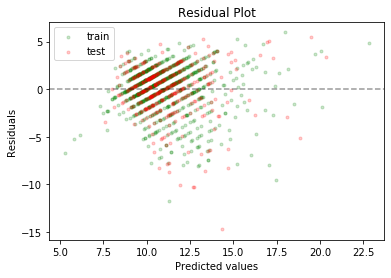

In [39]:
# F组模型训练、测试，并打印模型系数、截距，以及模型得分
regF = split_model_train_and_test('F',train_X,train_y,test_X,test_y)    # 当前组模型训练、测试
print(f'模型系数：{regF[0].coef_}，模型截距：{regF[0].intercept_}')
print(f'训练集R方得分：{regF[1]}，\n测试集R方得分：{regF[2]}')    # 输出当前组得分

模型系数：[[  5.61  10.22   8.72 -18.91 -11.    12.07]]，模型截距：[5.19]
训练集R方得分：0.45245761176984156，
测试集R方得分：0.39671296608918105


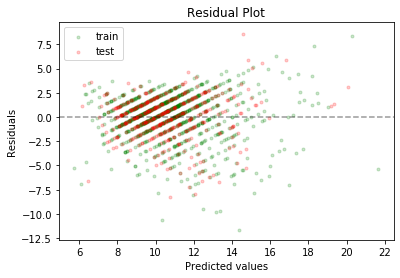

In [40]:
# M组模型训练、测试，并打印模型系数、截距，以及模型得分
regM = split_model_train_and_test('M',train_X,train_y,test_X,test_y)    # 当前组模型训练、测试
print(f'模型系数：{regM[0].coef_}，模型截距：{regM[0].intercept_}')
print(f'训练集R方得分：{regM[1]}，\n测试集R方得分：{regM[2]}')    # 输出当前组得分

模型系数：[[  5.34  23.98  10.73 -17.83 -16.3    8.89]]，模型截距：[2.69]
训练集R方得分：0.5846091294711961，
测试集R方得分：0.5865118756130969


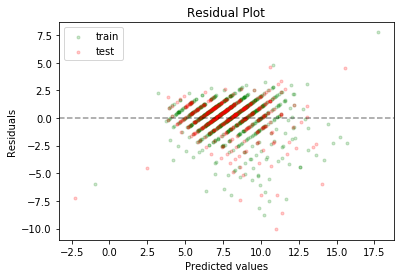

In [41]:
# I组模型训练、测试，并打印模型系数、截距，以及模型得分
regI = split_model_train_and_test('I',train_X,train_y,test_X,test_y)    # 当前组模型训练、测试
print(f'模型系数：{regI[0].coef_}，模型截距：{regI[0].intercept_}')
print(f'训练集R方得分：{regI[1]}，\n测试集R方得分：{regI[2]}')    # 输出当前组得分

#### 2 模型分析
线性回归模型的系数天然地可表示出特征对结果的影响，所以我们想通过分析模型的特征系数，来说明我们模型的好坏，而不是只根据R方得分。
- 首先，分割后的三个模型在6个特征上正负号一致，说明线性回归方法较为稳定，是合适的方法
- 其中，肉重量和内脏重量对年龄都是负影响，即肉重量、内脏重量越大，年龄越小
- 而另两个重量相关特征，晒干后重量和全部重量都是正影响，影响程度也差不多

模型分割的效果体现在高度和内脏重量这两个特征上，分割后的模型在这两个特征上系数的数值大小差别大。
- 对婴儿期的鲍鱼，高度是预测年龄的重要特征；而对F组的鲍鱼，预测年龄时高度非常不重要
- 对婴儿期的鲍鱼，肉重量和内脏重量对年龄的影响程度差不多；而F和M组的鲍鱼则不是这样，内脏重量的影响十分小于肉重量的影响，尤其是F组

可以看到，我们的模型能够较好地学习到不同组的特征，从而获得更好的预测能力，尤其是区分开了F和I。

<Figure size 432x288 with 0 Axes>

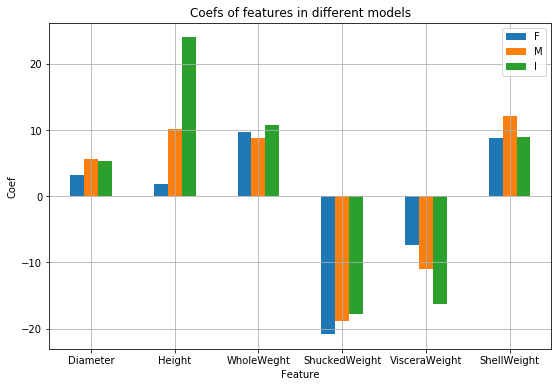

In [12]:
# 对三个模型的系数绘制柱状图，并分析
ft = ['Diameter', 'Height', 'WholeWeght', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight']
anl_df = pd.DataFrame(data={'F':regF[0].coef_[0], 'M':regM[0].coef_[0], 'I':regI[0].coef_[0],'Feature':ft})
plt.figure()
anl_df.plot.bar(x='Features',rot=0,figsize=(9,6))
plt.ylabel('Coefs')
plt.title('Coefs of features in different models')
plt.legend()
plt.grid(True)
plt.show()